<Body>   
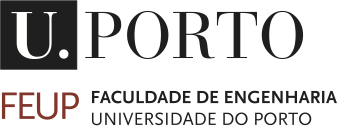   
<h1> <b>Perception and Mapping </b> </h1>
<p><b>Andry Maykol Pinto </b> (amgp@fe.up.pt)</p>
<p>Department of Electrical and Computer Engineering</p>
</Body>  
FEUP

---

# Enhancing Point Cloud Registration using the Robust Iterative Closest Point (R-ICP)

Point cloud registration is a fundamental task in computer vision and involves aligning two or more point clouds to find their relative transformation. The Iterative Closest Point (ICP) algorithm is widely used for this purpose. However, ICP is sensitive to outliers, noise, and initial alignment. In response to these limitations, the Robust Iterative Closest Point (Robust ICP) algorithm was developed. Robust ICP is designed to improve the accuracy and robustness of point cloud registration, even in the presence of challenging data.

One of the key challenges in point cloud registration is dealing with outliers. R-ICP is more resilient to noise in the data, making it suitable for real-world scenarios where data may be imperfect. The R-ICP addresses this challenge by explicitly considering the impact of outliers and assigning appropriate weights to data points. By iteratively refining the transformation estimate and focusing on inlier correspondences, Robust ICP often converges to more accurate solutions.

The R-ICP algorithm can be structured as it follows:

1. An initial transformation estimate is obtained, typically through a coarse alignment or using external information.

2. For each point in the source point cloud, the algorithm finds the corresponding point in the target point cloud. A common method is to search for the nearest neighbors in the target point cloud.

3. R-ICP introduces a mechanism to identify and reject outliers. Outliers are points that do not align well with the target point cloud and can significantly degrade registration accuracy.

4. For each point classified as outlier, R-ICP assigns lower weights but also assigns higher weights to inliers. This makes the algorithm more robust to noisy data.

5. Estimates a transformation that minimizes the distance between the source points and their corresponding points in the target cloud. Robust ICP uses a weighted optimization approach that assigns higher importance to inliers and less to outliers.

6. Steps 3 to 5 are repeated iteratively, refining the transformation estimate with each iteration. The optimization process continues until convergence or a predefined stopping criterion is met.


In [39]:
# Install Open3D library
!pip install open3d

In [40]:
# Import libraries
import numpy as np
import open3d as o3d
import copy

# Visualization
import plotly.graph_objects as go  # plotly to visualize since COLAB does not allow to use O3D functions
import matplotlib.pyplot as plt    # or, Matplotlib
from mpl_toolkits import mplot3d

In [41]:
# Visualize point cloud as a scatter plot using matplotlib (as an image!)
def plot_pointcloud_matplotlib_singleview (pt, title_ = ' ', view_ =(-90, 90, 0)):
  colors = None
  if pt.has_colors():
      colors = np.asarray(pt.colors)
  elif pt.has_normals():
      colors = (0.5, 0.5, 0.5) + np.asarray(pt.normals) * 0.5
  else:
      pt.paint_uniform_color((1.0, 0.0, 0.0))
      colors = np.asarray(pt.colors)

  points = np.asarray(pt.points)
  # Single View
  ax = plt.axes(projection='3d')
  ax.view_init(view_[0], view_[1], view_[2])
  ax.axis("on")
  ax.scatter(points[:,0], points[:,1], points[:,2], c=colors)
  ax.set_xlabel('X axis')
  ax.set_ylabel('Y axis')
  ax.set_zlabel('Z axis')

  plt.title(title_)
  plt.show()

#Plotly
def draw_geometries(geometries):
    graph_objects = []

    for geometry in geometries:
        geometry_type = geometry.get_geometry_type()

        if geometry_type == o3d.geometry.Geometry.Type.PointCloud:
            points = np.asarray(geometry.points)
            colors = None
            if geometry.has_colors():
                colors = np.asarray(geometry.colors)
            elif geometry.has_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.normals) * 0.5
                geometry.colors = o3d.utility.Vector3dVector(colors)
            else:
                geometry.paint_uniform_color((1.0, 0.0, 0.0))
                colors = np.asarray(geometry.colors)

            scatter_3d = go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], mode='markers', marker=dict(size=2, color=colors))
            graph_objects.append(scatter_3d)

        if geometry_type == o3d.geometry.Geometry.Type.TriangleMesh:
            triangles = np.asarray(geometry.triangles)
            vertices = np.asarray(geometry.vertices)
            colors = None
            if geometry.has_triangle_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))
            else:
                colors = (1.0, 0.0, 0.0)

            mesh_3d = go.Mesh3d(x=vertices[:,0], y=vertices[:,1], z=vertices[:,2], i=triangles[:,0], j=triangles[:,1], k=triangles[:,2], facecolor=colors, opacity=0.50)
            graph_objects.append(mesh_3d)

        if geometry_type == o3d.geometry.Geometry.Type.VoxelGrid:
            bounds     = geometry.get_max_bound()-geometry.get_min_bound()

            voxels     = geometry.get_voxels()   # Returns List of Voxel
            vox_mesh   = o3d.geometry.TriangleMesh()

            for v in voxels:
                cube = o3d.geometry.TriangleMesh.create_box(width=1, height=1, depth=1)
                cube.paint_uniform_color(v.color)
                cube.translate(v.grid_index, relative=False)
                vox_mesh += cube

            vox_mesh.translate([0.5,0.5,0.5], relative=True)

            vox_mesh.merge_close_vertices(0.0000001)
            # T=np.array([[1, 0, 0, 0],[0, 0, 1, 0],[0, -1, 0, 0],[0, 0, 0, 1]])
            vox_mesh.translate(geometry.origin, relative=True)

            # Now is like a TriangleMesh
            triangles = np.asarray(vox_mesh.triangles)
            vertices = np.asarray(vox_mesh.vertices)
            colors = None
            if vox_mesh.has_triangle_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(vox_mesh.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))
            else:
                vox_mesh.compute_vertex_normals()
                colors = (0.5, 0.5, 0.5) + np.asarray(vox_mesh.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))                                        # or colors = (0, 0, 0)

            mesh_3d = go.Mesh3d(x=vertices[:,0], y=vertices[:,1], z=vertices[:,2], i=triangles[:,0], j=triangles[:,1], k=triangles[:,2], facecolor=colors, opacity=0.50)
            graph_objects.append(mesh_3d)

    fig = go.Figure(
        data=graph_objects,
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        )
    )
    fig.show()


# Draw fitting results
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])       # orange
    target_temp.paint_uniform_color([0, 0.651, 0.929])   # blue (ref)
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])

In [42]:
o3d.visualization.draw_geometries = draw_geometries # replacing the function of Open3D

------------------

# Exercise: to develop a robust registration algorithm of 3D points using iteratively reweighted least squares

Develop a robustified version of ICP algorithm (R-ICP) that aligns two 3D point clouds by finding the transformation (rotation and translation) that minimizes the distances between corresponding points in the two clouds.

Implementation notes:

> Use a M-Estimator Charbonnier weight function with $\beta = 0.005$

> Assume that both point clouds (source and target) have the same sizes.

> Consider the point cloud extracted from the 'bunny mesh' and apply a known transformation matrix and noise.

> Compare the result of the R-ICP with the original transformation

> Compare the result of the R-ICP against the a result obtained from the original ICP method without RANSAC (aka the Vanilla ICP implementation developed in previous lecture). Discuss the results.




In [43]:
########################################################################################################
# DO NOT CHANGE THIS CODE

# Load MESH Bunny
bunny            = o3d.data.BunnyMesh()
mesh             = o3d.io.read_triangle_mesh(bunny.path)
mesh.compute_vertex_normals()
pcd              = o3d.geometry.PointCloud()
pcd.points       = mesh.vertices   # use vertexes as points
pcd_bunny        = o3d.geometry.PointCloud()

pcd_bunny.points = pcd.points[10:1010]       # use only partial pts

#Copy pts
bunny_target    = copy.deepcopy(pcd_bunny)

# Generate some noise
num_points       = len(pcd_bunny.points)
points_noise     = np.random.rand(num_points, 3)/100
np_pointcloud    = np.asarray(pcd_bunny.points)
for i in range(num_points) :
    np_pointcloud[i, 0] += points_noise[i, 0]
    np_pointcloud[i, 1] += points_noise[i, 1]
    np_pointcloud[i, 2] += points_noise[i, 2]
np_pointcloud [:-25] = np_pointcloud [:-25] - 0.1


bunny_source = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(np_pointcloud))

## APPLY a known rotation and translation
R = pcd_bunny.get_rotation_matrix_from_xyz((np.pi/8, 0, 0))    # Prepare rotation matrix
H         = np.eye(4)                                         # Prepare Transformation matrix
H[:3, :3] = R
H[0, 3]   = 0.005
H[1, 3]   = -0.005
H[2, 3]   = -0.003
print(H)

# Apply translation to the point cloud "bunny_source"
bunny_source.transform(H)
########################################################################################################

[[ 1.          0.          0.          0.005     ]
 [ 0.          0.92387953 -0.38268343 -0.005     ]
 [ 0.          0.38268343  0.92387953 -0.003     ]
 [ 0.          0.          0.          1.        ]]


PointCloud with 1000 points.

In [44]:
o3d.visualization.draw_geometries([bunny_source, bunny_target])

## a) Implement the ICP method

In [45]:

from sklearn.neighbors import NearestNeighbors
## Original ICP
def calculate_transform_lsq(A, B):
    '''
    Calculates the least-squares best-fit transform that maps corresponding points A to B in m spatial dimensions
    Input:
      A: Nxm numpy array of corresponding points
      B: Nxm numpy array of corresponding points
    Returns:
      T: (m+1)x(m+1) homogeneous transformation matrix that maps A on to B
      R: mxm rotation matrix
      t: mx1 translation vector
    '''
    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)

    AA = A - centroid_A
    BB = B - centroid_B

    H = AA.T @ BB
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    t = centroid_B.T - R @ centroid_A.T

    # homogeneous transformation
    T = np.identity(m+1)
    T[:m, :m] = R
    T[:m, m]  = t

    return T, R, t


def search_nearest_neighbor(src, dst):
    '''
    Find the nearest neighbor in dst for each point in src using Euclidean distance
    Input:
        src: Nxm array of points
        dst: Nxm array of points
    Output:
        distances: Euclidean distances of the nearest neighbor
        indices: dst indices of the nearest neighbor
    '''
    assert src.shape == dst.shape

    # https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(dst)
    distances, indices = neigh.kneighbors(src, return_distance=True)
    return distances.ravel(), indices.ravel()


def calculte_transform_icp(A, B, init_pose=None, max_iterations=20, tolerance=0.001):
    '''
    The Iterative Closest Point method: finds best-fit transform that maps points A on to points B
    Input:
        A: Nxm numpy array of source mD points
        B: Nxm numpy array of destination mD point
        init_pose: (m+1)x(m+1) homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
    Output:
        T: final homogeneous transformation that maps A on to B
        distances: Euclidean distances (errors) of the nearest neighbor
        i: number of iterations to converge
    '''

    # Point clouds must have the same size
    assert A.shape == B.shape

    # Number of dimensions of the point cloud
    m = A.shape[1]

    Tr = np.diag(np.ones(4), 0)

    # Use homogeneous points and copy them to maintain the originals
    src       = np.ones((m+1,A.shape[0]))
    dst       = np.ones((m+1,B.shape[0]))
    src[:m,:] = np.copy(A.T)
    dst[:m,:] = np.copy(B.T)
    src_iter  = np.copy(src)

    prev_error = 0

    # Consider the initial alignment transformation to source point cloud.
    if init_pose is not None:
        Tr  = init_pose

    # Iterate with a stop criteria: max_iterations
    for i in range(max_iterations):
      src_iter = Tr @ src

      distances, indices = search_nearest_neighbor(src_iter[:m,:].T, dst[:m,:].T)

      src_corr = src_iter[:m, :].T
      dst_corr = dst[:m, indices].T

      T, R, t= calculate_transform_lsq(src_corr, dst_corr)
      mean_error = np.mean(distances)

      #Save the transformation from the actual source cloudpoint to the destination
      Tr = T @ Tr

      # Stop criteria: convergence - check evolution of error
      if np.abs(prev_error - mean_error) < tolerance:
        break
        prev_error = mean_error

    return Tr, distances, i


## b) Implement  the R-ICP method

In [46]:
import numpy as np
from math import sqrt

def estimate_weights_charbonnier(distance, beta=0.005):
    return 1/np.sqrt(beta**2 + distance**2)

def calculate_transform_wlsq(A, B):
    '''
    Calculates the least-squares best-fit transform that maps corresponding points A to B in m spatial dimensions.
    Input:
      A: Nxm numpy array of corresponding points
      B: Nxm numpy array of corresponding points
    Returns:
      T: (m+1)x(m+1) homogeneous transformation matrix that maps A onto B
      R: mxm rotation matrix
      t: mx1 translation vector
    '''
    assert A.shape == B.shape

    # Get number of dimensions
    m = A.shape[1]

    # Compute weights based on distances
    distances = search_nearest_neighbor(A, B)[0]
    weight = estimate_weights_charbonnier(distances)

    # Calculate centroids
    centroid_A = np.sum(A * weight[:, np.newaxis], axis=0) / np.sum(weight)
    centroid_B = np.sum(B * weight[:, np.newaxis], axis=0) / np.sum(weight)

    AA = A - centroid_A
    BB = B - centroid_B

    # Compute covariance matrix and perform SVD
    H = AA.T @ (weight[:, np.newaxis] * BB)
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # Compute translation vector
    t = centroid_B - R @ centroid_A

    # Create homogeneous transformation matrix
    T = np.identity(m + 1)
    T[:m, :m] = R
    T[:m, m] = t

    return T, R, t, np.mean(weight)

def calculte_transform_ricp(A, B, init_pose=None, max_iterations=20, tolerance=0.001):
    '''
    The RIterative Closest Point method: finds the best-fit transform that maps points A onto points B.
    Input:
        A: Nxm numpy array of source mD points
        B: Nxm numpy array of destination mD points
        init_pose: (m+1)x(m+1) homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
    Output:
        T: final homogeneous transformation that maps A onto B
        distances: Euclidean distances (errors) of the nearest neighbor
        i: number of iterations to converge
    '''

    # Point clouds must have the same size
    assert A.shape == B.shape

    # Number of dimensions of the point cloud
    m = A.shape[1]

    Tr = np.identity(m + 1)

    # Use homogeneous points and copy them to maintain the originals
    src = np.ones((m + 1, A.shape[0]))
    dst = np.ones((m + 1, B.shape[0]))
    src[:m, :] = A.T
    dst[:m, :] = B.T
    src_iter = np.copy(src)

    prev_error = 0

    # Consider the initial alignment transformation to the source point cloud.
    if init_pose is not None:
        Tr = init_pose

    # Iterate with a stop criteria: max_iterations
    for i in range(max_iterations):
     src_iter[:m, :] = Tr[:m, :m] @ src[:m, :] + Tr[:m, m][:, np.newaxis]

    # Encontra as distâncias e os índices dos pontos mais próximos
     distances, closest_indices = search_nearest_neighbor(src_iter[:m, :].T, dst[:m, :].T)

     B_closest = dst[:m, closest_indices]

     weights = estimate_weights_charbonnier(distances.min(axis=0))

     T, R, t, mean_weigh = calculate_transform_wlsq(src_iter[:m, :].T, B_closest.T)

    # Atualiza a transformação total
     Tr = T @ Tr

     mean_error = np.mean(distances)

    # Critério de parada: convergência - verifica a evolução do erro
     if np.abs(prev_error - mean_error) < tolerance:
        break

     # Atualiza o erro anterior
     prev_error = mean_error

    return Tr, distances, i



## c) Discuss the results of ICP versus R-ICP



The ICP (Iterative Closest Point) and R-ICP (Robust ICP) are methods for aligning two point clouds.

ICP aligns corresponding points using a least-squares approach, treating all points equally and being highly sensitive to outliers, often resulting in less accurate alignment. Moreover, outliers in this method negatively affect the calculation of the transformation matrix, which can lead to a higher error (RMSE).

R-ICP, on the other hand, uses the Charbonnier function to evaluate each point based on its neighbors. This function has an inverse quadratic relationship between weight and distance, meaning that the greater the distance, the smaller the weight assigned to that point. This approach reduces the influence of outliers, resulting in a more accurate alignment and a lower RMSE. This method is more reliable in real-world applications, where data often contains noise or discrepancies.

### Evaluate the R-ICP

In [47]:
########################################################################################################
# DO NOT CHANGE THIS CODE

# Transformation (homogeneous coordinates: R|T )
trans_init = np.asarray([[1.0, 0.0, 0.0, 0.0],
                         [0.0, 1.0, 0.0, 0.0],
                         [0.0, 0.0, 1.0, 0.0],
                         [0.0, 0.0, 0.0, 1.0]])

pts_source = np.asarray(bunny_source.points)
pts_target = np.asarray(bunny_target.points)

min_points = min(len(pts_source), len(pts_target))-1

# Calculate the registration matrix
Transform, distances, i = calculte_transform_ricp(pts_source[:min_points, :], pts_target[:min_points, :], trans_init, 100, 0.0000001)
print(Transform)
print(i)
########################################################################################################

[[ 9.99932410e-01 -6.11624851e-04  1.16104396e-02  9.00682484e-02]
 [-3.89898823e-03  9.23147933e-01  3.84425144e-01  1.00112284e-01]
 [-1.09532773e-02 -3.84444429e-01  9.23083152e-01  9.43445940e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
32


In [48]:
# Performance of the R-ICP
draw_registration_result(bunny_source, bunny_target, Transform)

threshold  = 0.05
evaluation = o3d.pipelines.registration.evaluate_registration(bunny_source, bunny_target, threshold, Transform)
print('after ICP :::', evaluation)

after ICP ::: RegistrationResult with fitness=9.750000e-01, inlier_rmse=3.644431e-03, and correspondence_set size of 975
Access transformation to get result.


### Evaluate the ICP

In [49]:
########################################################################################################
# DO NOT CHANGE THIS CODE
# Performance of the ICP

Transform, distances, i = calculte_transform_icp(pts_source[:min_points, :], pts_target[:min_points, :], trans_init, 100, 0.0000001)
print(Transform)
print("Numero de iterações ate convergir:",i)

threshold  = 0.05
evaluation = o3d.pipelines.registration.evaluate_registration(bunny_source, bunny_target, threshold, Transform)
print('after ICP :::', evaluation)

draw_registration_result(bunny_source, bunny_target, Transform)
########################################################################################################

[[ 0.97402738 -0.00771616  0.22629873  0.09596734]
 [-0.09513467  0.89298183  0.43992368  0.09278622]
 [-0.20547518 -0.45002657  0.86905468  0.06413508]
 [ 0.          0.          0.          1.        ]]
Numero de iterações ate convergir: 99
after ICP ::: RegistrationResult with fitness=9.750000e-01, inlier_rmse=8.194326e-03, and correspondence_set size of 975
Access transformation to get result.


**Provide some comments about the differences between R-ICP and the original ICP.**

<font color='green'>
<<< introduce justification here

<<< introduce justification here

<<< introduce justification here

<<< introduce justification here
</font>




--------------------------
--------------------------


It's DONE!

**Instructions for submitting this work:**
* This colab file must be executed before the delivery.

* The code must be ready to run without permissions for accessing shared folders.

* To avoid problems with the Plotly, please encode an image in this colab (from printscreen) for each core result that you have.
--------------------------

<font color='red'>
Disclaimer for the use of AI tools: complete the text that is placed in between brackets. Convert this disclaimer to PDF, sign it and deliver the PDF in Moodle.
</font>

I, Bernardo Dias, declare that the work presented in this assignment titled "Assignment1_ICP_RICP" was completed independently, except where explicitly noted. I confirm the following with regard to the use of AI tools:

**Extent of AI Tool Contribution:**

I have used the following AI tool(s) for assistance in this assignment:

1. Tool(s) Used: ChatGPT
Nature of Assistance: Helping to understand the theorical part of both methods and use of some functions regarding Matrix Manipulation
2. Percentage of AI Contribution: 50%
3. Human Oversight and Contribution:
Despite the use of AI tools, I confirm that the critical thinking, analysis, problem-solving, and final decision-making processes in this assignment were carried out by me. The AI tools were used solely as support for the following purposes: ChatGPT helped on understanding the methods to use especially in the ICP method,the R-ICP was simillar but in the ICP the AI tool helped understanding what to do and to separate the method by parts, making it easier to do the code and understand how it works.


**Originality and Integrity:**
I take full responsibility for ensuring that the content of this assignment is original and properly cited where applicable. The use of AI tools did not result in any unintentional plagiarism or misrepresentation of ideas from external sources.

**Compliance with Academic Integrity Guidelines:**
I understand the importance of academic integrity, and I confirm that the usage of AI tools complies with the guidelines provided by FEUP. All AI-generated outputs were critically evaluated and appropriately incorporated into the final submission.

Signed,
Bernardo Dias
31/10/2024